## Collaborative Filtering

These notebook will compare the performance of _Neural Collaborative Filtering_ **[1]** and _Neural Graph Collaborative Filtering_ **[2]** papers on MovieLens dataset. We would like to see if there is a difference between non-graph based method and a graph-based method on collaborative filtering using MovieLens dataset. We will benefit from [this GitHub repository](https://github.com/talkingwallace/NGCF-pytorch/blob/master/GraphNCF/GCFmodel.py) **[3]** for the implementation of these two models.

__Neural Collaborative Filtering:__ When it comes to model the key factor in collaborative filtering -- the interaction between user and item features, they still resorted to matrix factorization and applied an inner product on the latent features of users and items. By replacing the inner product with a neural architecture that can learn an arbitrary function from data, we present a general framework named NCF, short for Neural network-based Collaborative Filtering.

__Neural Graph Collaborative Filtering:__ In this work, we propose to integrate the user-item interactions --- more specifically the bipartite graph structure --- into the embedding process. We develop a new recommendation framework Neural Graph Collaborative Filtering (NGCF), which exploits the user-item graph structure by propagating embeddings on it. 

***

### Libraries

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.nn import MSELoss
import time

np.random.seed(23)

### Data Preprocessing

In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class RatingsDataset(Dataset):
    """Ratings Dataset"""

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with ratings.
        """
        self.csv = pd.read_csv('data/ratings.csv')
        
        self.user_ids = list(self.csv.user_id-1)
        self.movie_ids = list(self.csv.movie_id_ml-1)
        self.ratings = list(self.csv.rating)
        
        self.userNums = np.max(self.user_ids)+1
        self.movieNums = np.max(self.movie_ids)+1

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return {
            'user': self.user_ids[idx],
            'movie': self.movie_ids[idx], 
            'rating': self.ratings[idx]
        }
    
    def get_user_number(self):
        return self.userNums
    
    def get_movie_number(self):
        return self.movieNums

In [14]:
rt = pd.read_csv('data/ratings.csv')
rt['user_id'] = rt['user_id'] - 1
rt['movie_id_ml'] = rt['movie_id_ml'] - 1

dataset = RatingsDataset()

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### Model Implementation - Neural Collaborative Filtering 

In [15]:
class NCF(Module):

    def __init__(self, userNum, itemNum, dim=64, first_layer=128):
        super(NCF, self).__init__()
        
        self.uEmbd = nn.Embedding(userNum, dim)
        self.iEmbd = nn.Embedding(itemNum, dim)
        
        self.mf_uEmbd = nn.Embedding(userNum, dim)
        self.mf_iEmbd = nn.Embedding(itemNum, dim)
        
        self.mlp = nn.Sequential(nn.Linear(dim*2, first_layer),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer, first_layer//2),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//2, first_layer//4),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//4, first_layer//4))
        
        self.neumf = nn.Linear(dim+first_layer//4, 1)
        
    def forward(self, userIdx,itemIdx):
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        embd = torch.cat([uembd, iembd], dim=1)
    
        mlp = self.mlp(embd)
        mf = self.uEmbd(userIdx)*self.iEmbd(itemIdx)
        
        prediction = self.neumf(torch.cat([mlp, mf], dim=1))
        
        return prediction.flatten()

### Model Implementation - Neural Graph Collaborative Filtering 

In [16]:
class GNNLayer(Module):

    def __init__(self,inF,outF):

        super(GNNLayer,self).__init__()
        self.inF = inF
        self.outF = outF
        self.linear = torch.nn.Linear(in_features=inF,out_features=outF)
        self.interActTransform = torch.nn.Linear(in_features=inF,out_features=outF)

    def forward(self, laplacianMat,selfLoop,features):
        L1 = laplacianMat + selfLoop
        L2 = laplacianMat.cuda()
        L1 = L1.cuda()
        inter_feature = torch.mul(features,features)

        inter_part1 = self.linear(torch.sparse.mm(L1,features))
        inter_part2 = self.interActTransform(torch.sparse.mm(L2,inter_feature))

        return inter_part1+inter_part2
    
class NGCF(Module):

    def __init__(self,userNum,itemNum,rt,embedSize=100,layers=[100,80,50],useCuda=True):

        super(NGCF,self).__init__()
        self.useCuda = useCuda
        self.userNum = userNum
        self.itemNum = itemNum
        self.uEmbd = nn.Embedding(userNum,embedSize)
        self.iEmbd = nn.Embedding(itemNum,embedSize)
        self.GNNlayers = torch.nn.ModuleList()
        self.LaplacianMat = self.buildLaplacianMat(rt) # sparse format
        self.selfLoop = self.getSparseEye(self.userNum+self.itemNum)

        self.transForm1 = nn.Linear(in_features=layers[-1]*(len(layers))*2,out_features=64)
        self.transForm2 = nn.Linear(in_features=64,out_features=32)
        self.transForm3 = nn.Linear(in_features=32,out_features=1)

        for From,To in zip(layers[:-1],layers[1:]):
            self.GNNlayers.append(GNNLayer(From,To))

    def getSparseEye(self,num):
        i = torch.LongTensor([[k for k in range(0,num)],[j for j in range(0,num)]])
        val = torch.FloatTensor([1]*num)
        return torch.sparse.FloatTensor(i,val)

    def buildLaplacianMat(self,rt):

        rt_item = rt['movie_id_ml'] + self.userNum
        uiMat = coo_matrix((rt['rating'], (rt['user_id'], rt['movie_id_ml'])))

        uiMat_upperPart = coo_matrix((rt['rating'], (rt['user_id'], rt_item)))
        uiMat = uiMat.transpose()
        uiMat.resize((self.itemNum, self.userNum + self.itemNum))

        A = sparse.vstack([uiMat_upperPart,uiMat])
        selfLoop = sparse.eye(self.userNum+self.itemNum)
        sumArr = (A>0).sum(axis=1)
        diag = list(np.array(sumArr.flatten())[0])
        diag = np.power(diag,-0.5)
        D = sparse.diags(diag)
        L = D * A * D
        L = sparse.coo_matrix(L)
        row = L.row
        col = L.col
        i = torch.LongTensor([row,col])
        data = torch.FloatTensor(L.data)
        SparseL = torch.sparse.FloatTensor(i,data)
        return SparseL

    def getFeatureMat(self):
        uidx = torch.LongTensor([i for i in range(self.userNum)])
        iidx = torch.LongTensor([i for i in range(self.itemNum)])
        if self.useCuda == True:
            uidx = uidx.cuda()
            iidx = iidx.cuda()

        userEmbd = self.uEmbd(uidx)
        itemEmbd = self.iEmbd(iidx)
        features = torch.cat([userEmbd,itemEmbd],dim=0)
        return features

    def forward(self,userIdx,itemIdx):

        itemIdx = itemIdx + self.userNum
        userIdx = list(userIdx.cpu().data)
        itemIdx = list(itemIdx.cpu().data)
        # gcf data propagation
        features = self.getFeatureMat()
        finalEmbd = features.clone()
        for gnn in self.GNNlayers:
            features = gnn(self.LaplacianMat,self.selfLoop,features)
            features = nn.LeakyReLU()(features)
            finalEmbd = torch.cat([finalEmbd,features.clone()],dim=1)

        userEmbd = finalEmbd[userIdx]
        itemEmbd = finalEmbd[itemIdx]
        embd = torch.cat([userEmbd,itemEmbd],dim=1)

        embd = nn.ReLU()(self.transForm1(embd))
        embd = nn.ReLU()(self.transForm2(embd))
        embd = self.transForm3(embd)
        prediction = embd.flatten()

        return prediction

### Training

In [17]:
def train(loader, model, optim, loss):
    model.train()
    ls = 0.
    
    for id, batch in enumerate(loader):
        optim.zero_grad()
        prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0))
        loss_ = loss(batch['rating'].float().cuda(0), prediction)
        loss_.backward()
        optim.step()
        ls += loss_.item()
        
    return ls / len(loader)


def evaluate(loader, model, loss):
    model.eval()
    ls = 0.

    with torch.no_grad():
        for id, batch in enumerate(loader):
            prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0))
            loss_ = loss(batch['rating'].float().cuda(0), prediction)
            ls += loss_.item()
            
    return ls / len(loader)

In [18]:
def trainer(trainLoader, valLoader, model, optim, loss, epoch, model_name, verbose=True):
    
    train_losses = []
    val_losses = []

    best_val = np.inf

    for i in range(epoch):
        start = time.time()
        TL = train(trainLoader, model, optim, loss)
        VL = evaluate(valLoader, model, loss)
        
        if verbose:
            print("Epoch {} | Train Loss: {:.3f} - Val Loss: {:.3f} - in {:.3f} mins.".format(i+1, TL, VL, (time.time()-start)/60))

        if VL < best_val:
            torch.save(model.state_dict(), model_name + '.pth.tar')
            best_val = VL

        train_losses.append(TL)
        val_losses.append(VL)
        
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'min_val_loss': min(val_losses)
    }, model_name + '_loss.pth.tar')
        
    return torch.load(model_name + '_loss.pth.tar')

### NeuMF Training

In [19]:
EMBEDDING_DIM = 64

GRID_SEARCH = {
    'batch_size': [128, 256, 512],
    'first_layer': [64, 128, 256],
    'learning_rate': [1e-3, 1e-2]
}

In [27]:
for bs in GRID_SEARCH['batch_size']:
    for layer in GRID_SEARCH['first_layer']:
        for lr in GRID_SEARCH['learning_rate']:
            
            trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
            valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)
            
            model = NCF(dataset.get_user_number(), dataset.get_movie_number(), 
                        dim=EMBEDDING_DIM, first_layer=layer).cuda(0)
            
            optim = Adam(model.parameters(), lr=lr)
            loss = nn.L1Loss()
            epoch = 20
            
            ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)
            
            print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs, 
                                                                                                            layer, 
                                                                                                            lr, 
                                                                                                            ncf_out['min_val_loss']))

Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. Loss: 0.7356434101477648
Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. Loss: 0.8046537175392493
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. Loss: 0.7446408038720106
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.01 - Min. Val. Loss: 0.790501879575925
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.001 - Min. Val. Loss: 0.7619099525304941
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.01 - Min. Val. Loss: 0.8142971514891355
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. Loss: 0.7693888277579577
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. Loss: 0.787121845361514
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. Loss: 0.739997902741799
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.01 - Min. Val. Loss: 0.778801692

In [20]:
bs = 128
layer = 64
lr = 1e-3
EMBEDDING_DIM = 64

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
valLoader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

model = NCF(dataset.get_user_number(), dataset.get_movie_number(), 
            dim=EMBEDDING_DIM, first_layer=layer).cuda(0)

optim = Adam(model.parameters(), lr=lr)
loss = nn.L1Loss()
epoch = 40

nf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)

print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs, 
                                                                                                layer, 
                                                                                                lr, 
                                                                                                nf_out['min_val_loss']))

Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. Loss: 0.7644386883729544


### NGCF Training

In [21]:
EMBEDDING_DIM = 64

GRID_SEARCH = {
    'batch_size': [256, 512, 1024],
    'layers': [[64,64], [64,64,64], [64,64,64,64]]
}

In [31]:
for bs in GRID_SEARCH['batch_size']:
    for layer in GRID_SEARCH['layers']:     
        
        trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
        valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

        model = NGCF(dataset.get_user_number(), dataset.get_movie_number(), rt, EMBEDDING_DIM, layers=layer).cuda(0)
        optim = Adam(model.parameters(), lr=1e-3)
        loss = nn.L1Loss()
        epoch = 20

        ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ngcf_model', False)

        print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs, 
                                                                                                        layer, 
                                                                                                        lr, 
                                                                                                        ncf_out['min_val_loss']))

Batch Size: 256 | First Layer Neuron: [64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7478925876128368
Batch Size: 256 | First Layer Neuron: [64, 64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.723776468863854
Batch Size: 256 | First Layer Neuron: [64, 64, 64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7210972034014188
Batch Size: 512 | First Layer Neuron: [64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.746336606832651
Batch Size: 512 | First Layer Neuron: [64, 64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7237180119905716
Batch Size: 512 | First Layer Neuron: [64, 64, 64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7286107692963038
Batch Size: 1024 | First Layer Neuron: [64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7496198196160165
Batch Size: 1024 | First Layer Neuron: [64, 64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7319987290783933
Batch Size: 1024 | First Layer Neuron: [64, 64, 64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7402098335717854


In [22]:
bs = 256
layer = [64, 64, 64, 64]

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
valLoader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

model = NGCF(dataset.get_user_number(), dataset.get_movie_number(), rt, EMBEDDING_DIM, layers=layer).cuda(0)
optim = Adam(model.parameters(), lr=1e-3)
loss = nn.L1Loss()
epoch = 40

ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ngcf_model', False)

print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs, 
                                                                                                layer, 
                                                                                                lr, 
                                                                                                ncf_out['min_val_loss']))

Batch Size: 256 | First Layer Neuron: [64, 64, 64, 64] | Learning Rate: 0.001 - Min. Val. Loss: 0.7207981141713949


### Training Results

In [4]:
nf_out = torch.load('ncf_model_loss.pth.tar')
ncf_out = torch.load('ngcf_model_loss.pth.tar')

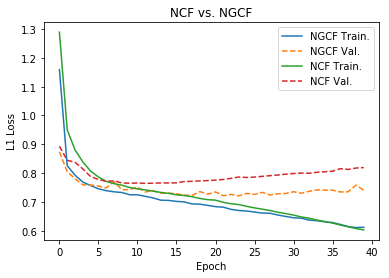

In [23]:
plt.title('NCF vs. NGCF')
plt.plot(ncf_out['train_losses'], label='NGCF Train.')
plt.plot(ncf_out['val_losses'], label='NGCF Val.', linestyle='--')
plt.plot(nf_out['train_losses'], label='NCF Train.')
plt.plot(nf_out['val_losses'], label='NCF Val.', linestyle='--')
_ = plt.ylabel('L1 Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend()
plt.savefig('ncf_ngcf.png', bbox_inches='tight', dpi=200)

***

## References

[1] _He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. International World Wide Web Conferences Steering Committee, 2017._

[2] _Wang, Xiang, et al. "Neural Graph Collaborative Filtering." arXiv preprint arXiv:1905.08108 (2019)._

[3] _https://github.com/talkingwallace/NGCF-pytorch_